1 L.ibrary Imports

This cell installs all the necessary additional libraries.

In [15]:
!pip install scikit-learn -q
!pip install wbdata -q

This cell imports all the necessary libraries.

In [66]:
import logging
import warnings
# Suppresses warning errors, there are too many of them there about caches from wbdata
logging.getLogger("shelved_cache.persistent_cache").setLevel(logging.ERROR)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")
import wbdata
import pandas as pd
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from data_handler import Data_Handler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import pycountry

# 2. Datasets
## 2.1 Pulling the data
Add a description of which indicators we chose for each data set and why

In [86]:
# Initialise data indicators and relative names for the columns in the data
indicators_gidd = {
    "new_displacement": "New displacement",
    "hazard_type_name": "Hazard type"
}

indicators_hdi = {
    "gnipc": "Gross National Income Per Capita",
    "ineq_inc": "Income Inequality",
    "le": "Life Expectancy at Birth",
    "gii": "Gender Inequality Index",
}

indicators_wb = {
    "EN.POP.DNST": "population_density",
    "SP.DYN.IMRT.IN": "infant_mortality_rate",
    "SL.EMP.TOTL.SP.ZS": "employment_rate",
}
# Get GIDD data
disp_data = Data_Handler.get_data_GIDD(
    client_id="92DWGXNPOLOM7DR6",
    indicators = indicators_gidd,
    iso3=None,
    start_year=2013,
    end_year=2023,
)
# Get HDI data
hdi_data = Data_Handler.get_data_HDI(
    filepath="HDR25_Composite_indices_complete_time_series.csv",
    indicators=indicators_hdi,
    countries=None,
    start_year=2013,
    end_year=2023
)
# Get WB data
wbdata = Data_Handler.get_data_WB(
    indicators = indicators_wb, 
    countries="all", 
    start_year=2013,
    end_year=2023
 )


do we want one column per  year and country or have it per event ??

In [87]:
# Pivot the HDI dataset so that each metric_name becomes a column
hdi_data_pivot = hdi_data.pivot_table(
    index=['iso3', 'year'],   
    columns='metric_name',       
    values='value'               
).reset_index()                  

# Rename columns for consistency
wbdata.rename(columns={'Year': 'year'}, inplace=True)
wbdata.rename(columns={'ISO3': 'iso3'}, inplace=True)

# Merge datasets on 'iso3' and 'year'
se_data = (hdi_data_pivot
        .merge(wbdata, on=['iso3', 'year'], how='outer')
       )

In [88]:
# Function to get country names from ISO3 codes
def iso3_to_name(codes):
    names = []
    for code in codes:
        try:
            country = pycountry.countries.get(alpha_3=code)
            names.append(f"{code} ({country.name})")
        except:
            names.append(f"{code} (Unknown)")
    return sorted(names)

# Your sets
hdi_iso3 = set(hdi_data_pivot['iso3'].unique())
gidd_iso3 = set(gidd_data['iso3'].unique())
wbdata_iso3 = set(wbdata['iso3'].unique())

# Compute unique codes
only_hdi = hdi_iso3 - wbdata_iso3
only_wb = wbdata_iso3 - hdi_iso3

# Print with country names
print("ISO3 codes only in HDI:", iso3_to_name(only_hdi))
print("ISO3 codes only in WBData:", iso3_to_name(only_wb))

ISO3 codes only in HDI: ['ZZA.VHHD (Unknown)', 'ZZB.HHD (Unknown)', 'ZZC.MHD (Unknown)', 'ZZD.LHD (Unknown)', 'ZZE.AS (Unknown)', 'ZZF.EAP (Unknown)', 'ZZG.ECA (Unknown)', 'ZZH.LAC (Unknown)', 'ZZI.SA (Unknown)', 'ZZJ.SSA (Unknown)', 'ZZK.WORLD (Unknown)']
ISO3 codes only in WBData: [' (Unknown)', 'ABW (Aruba)', 'AFE (Unknown)', 'AFW (Unknown)', 'ARB (Unknown)', 'ASM (American Samoa)', 'BMU (Bermuda)', 'CEB (Unknown)', 'CHI (Unknown)', 'CSS (Unknown)', 'CUW (Curaçao)', 'CYM (Cayman Islands)', 'EAP (Unknown)', 'EAR (Unknown)', 'EAS (Unknown)', 'ECA (Unknown)', 'ECS (Unknown)', 'EMU (Unknown)', 'EUU (Unknown)', 'FCS (Unknown)', 'FRO (Faroe Islands)', 'GIB (Gibraltar)', 'GRL (Greenland)', 'GUM (Guam)', 'HPC (Unknown)', 'IBD (Unknown)', 'IBT (Unknown)', 'IDA (Unknown)', 'IDB (Unknown)', 'IDX (Unknown)', 'IMN (Isle of Man)', 'LAC (Unknown)', 'LCN (Unknown)', 'LDC (Unknown)', 'LMY (Unknown)', 'LTE (Unknown)', 'MAC (Macao)', 'MAF (Saint Martin (French part))', 'MEA (Unknown)', 'MIC (Unknown)'

In [89]:
# Find the intersection of ISO3 codes
hdi_iso3 = set(hdi_data_pivot['iso3'].dropna().unique())
wbdata_iso3 = set(wbdata['iso3'].unique())

common_iso3 = hdi_iso3 & wbdata_iso3 # intersection

# Keep only rows in `data` with ISO3 codes in both datasets and not missing
se_data = se_data[se_data['iso3'].isin(common_iso3) & se_data['iso3'].notna()]
disp_data = disp_data[disp_data['iso3'].isin(common_iso3) & disp_data['iso3'].notna()]


In [90]:
# Country to ISO3 dictionaries
south_asia = {
    "Bangladesh": "BGD",
    "Bhutan": "BTN",
    "India": "IND",
    "Maldives": "MDV",
    "Nepal": "NPL",
    "Pakistan": "PAK",
    "Sri Lanka": "LKA"
}

east_asia = {
    "China": "CHN",
    "Hong Kong": "HKG",
    "Macau": "MAC",
    "Japan": "JPN",
    "North Korea": "PRK",
    "South Korea": "KOR",
    "Chinese Taipei": "TWN",
    "Mongolia": "MNG"
}

southeast_asia = {
    "Brunei": "BRN",
    "Cambodia": "KHM",
    "Indonesia": "IDN",
    "Laos": "LAO",
    "Malaysia": "MYS",
    "Myanmar": "MMR",
    "Philippines": "PHL",
    "Singapore": "SGP",
    "Thailand": "THA",
    "Timor-Leste": "TLS",
    "Vietnam": "VNM"
}

# Function to find missing countries by ISO3
def find_missing_iso(region_dict, iso_list):
    return [country for country, iso in region_dict.items() if iso not in iso_list]

# Compare each region
missing_south_asia = find_missing_iso(south_asia, common_iso3)
missing_east_asia = find_missing_iso(east_asia, common_iso3)
missing_southeast_asia = find_missing_iso(southeast_asia, common_iso3)

print("Missing South Asia:", missing_south_asia)
print("Missing East Asia:", missing_east_asia)
print("Missing Southeast Asia:", missing_southeast_asia)


Missing South Asia: []
Missing East Asia: ['Macau', 'Chinese Taipei']
Missing Southeast Asia: []


In [91]:
# Filter region dicts to only include ISO3 codes that are in common_iso3
filtered_south_asia_iso = [iso for iso in south_asia.values() if iso in common_iso3]
filtered_east_asia_iso = [iso for iso in east_asia.values() if iso in common_iso3]
filtered_southeast_asia_iso = [iso for iso in southeast_asia.values() if iso in common_iso3]

# Combine all filtered ISO3 codes into a set
allowed_iso3 = set(filtered_south_asia_iso + filtered_east_asia_iso + filtered_southeast_asia_iso)

# Filter your datasets
se_data = se_data[se_data['iso3'].isin(allowed_iso3)]
disp_data = disp_data[disp_data['iso3'].isin(allowed_iso3)]


In [92]:
print(len(allowed_iso3), iso3_to_name(allowed_iso3))

24 ['BGD (Bangladesh)', 'BRN (Brunei Darussalam)', 'BTN (Bhutan)', 'CHN (China)', 'HKG (Hong Kong)', 'IDN (Indonesia)', 'IND (India)', 'JPN (Japan)', 'KHM (Cambodia)', 'KOR (Korea, Republic of)', "LAO (Lao People's Democratic Republic)", 'LKA (Sri Lanka)', 'MDV (Maldives)', 'MMR (Myanmar)', 'MNG (Mongolia)', 'MYS (Malaysia)', 'NPL (Nepal)', 'PAK (Pakistan)', 'PHL (Philippines)', "PRK (Korea, Democratic People's Republic of)", 'SGP (Singapore)', 'THA (Thailand)', 'TLS (Timor-Leste)', 'VNM (Viet Nam)']


## 2.2 Data preprocessing
In this section, we complete all necessary data preprocessing.

We plotted the missing values by year in a bar graph.

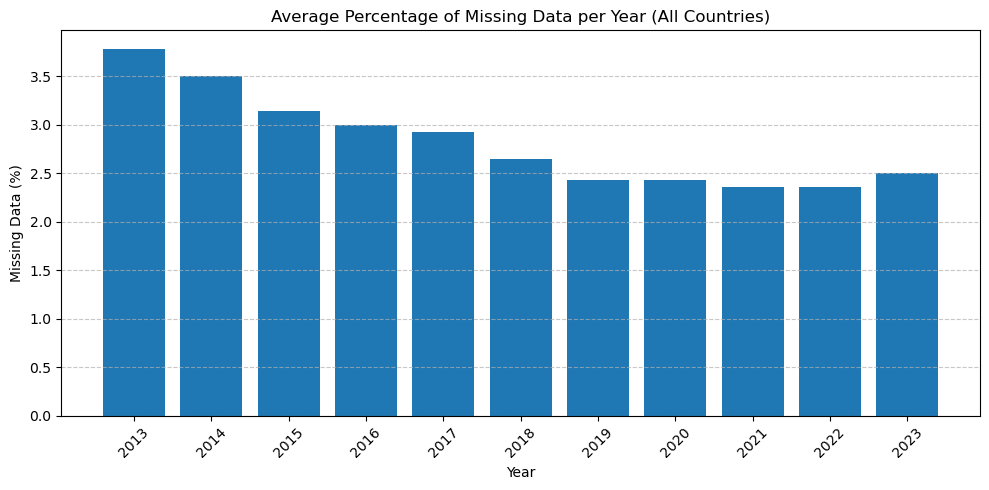

In [93]:
# Exclude trivial columns
cols_to_check = [c for c in se_data.columns if c not in ['year', 'iso3']]

# Percentage of NaN values per year (average across all countries and columns)
nan_by_year = data.groupby('year')[cols_to_check].apply(lambda x: x.isna().mean().mean() * 100)

# Plot NaN values
plt.figure(figsize=(10,5))
plt.bar(nan_by_year.index.astype(str), nan_by_year.values)
plt.title('Average Percentage of Missing Data per Year (All Countries)')
plt.xlabel('Year')
plt.ylabel('Missing Data (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Although the dataset contains missing values, missingness is not uniform across time. Missing data are highest in the early period (2013–2016, approximately 35–45%), decrease substantially in 2017 (≈20%), and 2018 (≈10%). From there onwards it remains low around 10% except for 2021.

Excluding early years would therefore disproportionately remove information from the beginning of the analysis period and compress the time dimension. Because the missingness declines  over time and is driven primarily by data availability rather than  changes in the underlying phenomena, retaining all years allows temporal continuity.

Next, we plot countries and the percentage of missing values per country.

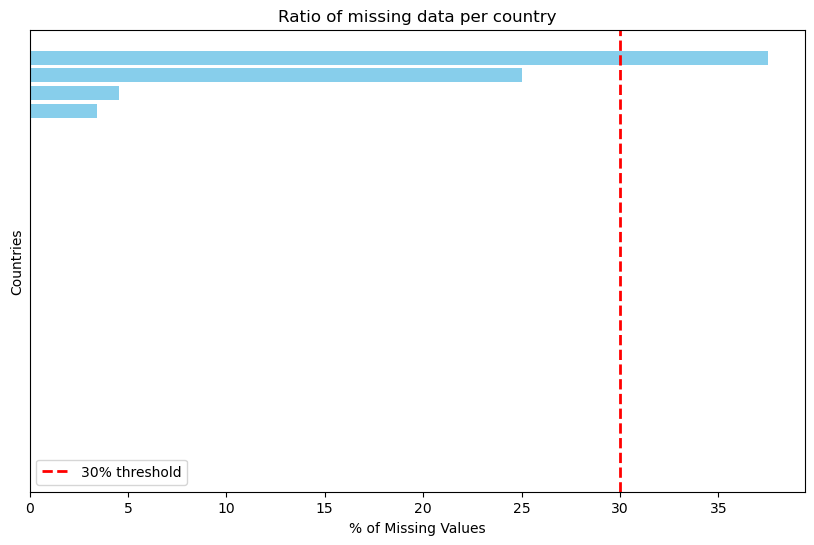

In [94]:
# Get NaN values by country
nan_by_country = se_data.groupby('iso3')[cols_to_check].apply(lambda x: x.isna().mean().mean() * 100)
nan_by_country = nan_by_country.sort_values(ascending=False)

# Plot NaN values
plt.figure(figsize=(10,6))
plt.barh(range(len(nan_by_country)), nan_by_country.values, color='skyblue')  # use range for no labels
plt.axvline(x=30, color='red', linestyle='--', linewidth=2, label='30% threshold')  # red line at 30%
plt.xlabel('% of Missing Values')
plt.ylabel("Countries")
plt.title('Ratio of missing data per country')
plt.yticks([])  # remove y-axis labels
plt.legend()
plt.gca().invert_yaxis()  # largest on top
plt.show()


From the graph, we can see that a lot of the countries have a majority of their data missing. We have decided to exclude countries that have more than 70 per cent data missing, which is indicated by the red line in the graph.

Now, we want to inspect the trends of missing data between different factors in our dataset.

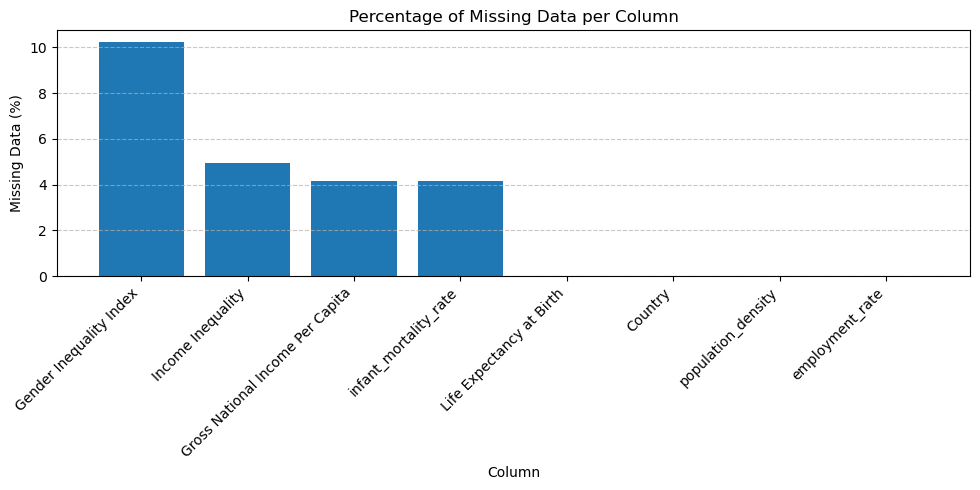


Missing data percentage per column (sorted):
Gender Inequality Index             10.227273
Income Inequality                    4.924242
Gross National Income Per Capita     4.166667
infant_mortality_rate                4.166667
Life Expectancy at Birth             0.000000
Country                              0.000000
population_density                   0.000000
employment_rate                      0.000000
dtype: float64


In [95]:
# Get NaN values per column
nan_per_column = se_data[cols_to_check].isna().mean() * 100
nan_per_column_sorted = nan_per_column.sort_values(ascending=False)

# Plot NaN values
plt.figure(figsize=(10,5))
plt.bar(nan_per_column_sorted.index, nan_per_column_sorted.values)
plt.title(f'Percentage of Missing Data per Column')
plt.xlabel('Column')
plt.ylabel('Missing Data (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nMissing data percentage per column (sorted):")
print(nan_per_column_sorted)

There is no feature with  significant amount of missing data wherefore we can keep all chosen indicators.

In [96]:
import pandas as pd

# Assuming your dataset is already loaded as se_data
# se_data = pd.read_csv('your_dataset.csv')

# Check which columns have missing data
print(se_data.isnull().sum())

# Interpolation (good for numerical, continuous data)
# Method='linear' fills missing values based on neighboring data
se_data['Gender Inequality Index'] = se_data['Gender Inequality Index'].interpolate(method='linear')
se_data['infant_mortality_rate'] = se_data['infant_mortality_rate'].interpolate(method='linear')
se_data['Income Inequality'] = se_data['Income Inequality'].interpolate(method='linear')

# If you want to do extrapolation for missing values at the start or end, you can use 'fillna' with method='bfill' or 'ffill'
# Forward fill
se_data['Gender Inequality Index'] = se_data['Gender Inequality Index'].fillna(method='ffill')
se_data['infant_mortality_rate'] = se_data['infant_mortality_rate'].fillna(method='ffill')
se_data['Income Inequality'] = se_data['Income Inequality'].fillna(method='ffill')

# Backward fill as backup
se_data['Gender Inequality Index'] = se_data['Gender Inequality Index'].fillna(method='bfill')
se_data['infant_mortality_rate'] = se_data['infant_mortality_rate'].fillna(method='bfill')
se_data['Income Inequality'] = se_data['Income Inequality'].fillna(method='bfill')

# Check again for missing values
print(se_data.isnull().sum())


iso3                                 0
year                                 0
Gender Inequality Index             27
Gross National Income Per Capita    11
Income Inequality                   13
Life Expectancy at Birth             0
Country                              0
population_density                   0
infant_mortality_rate               11
employment_rate                      0
dtype: int64
iso3                                 0
year                                 0
Gender Inequality Index              0
Gross National Income Per Capita    11
Income Inequality                    0
Life Expectancy at Birth             0
Country                              0
population_density                   0
infant_mortality_rate                0
employment_rate                      0
dtype: int64


## 2.3 Uniformize data
Next, we look at the minimum and maximum values each column can obtain. 

In [97]:
numeric_cols = ["employment_rate", "population_density", "infant_mortality_rate", "Gender Inequality Index", "Income Inequality", "Gross National Income Per Capita", "Life Expectancy at Birth"]
# Print min and max values of each column
min_max = se_data[numeric_cols].agg(["min", "max"]).transpose().reset_index()
min_max.columns = ["Column", "min", "max"]
print(min_max)

                             Column          min            max
0                   employment_rate    34.306000      82.328000
1                population_density     1.861618    8241.849582
2             infant_mortality_rate     1.700000      67.900000
3           Gender Inequality Index     0.030000       0.578000
4                 Income Inequality    11.196431      40.396561
5  Gross National Income Per Capita  3253.885007  112141.234300
6          Life Expectancy at Birth    64.617000      85.511000


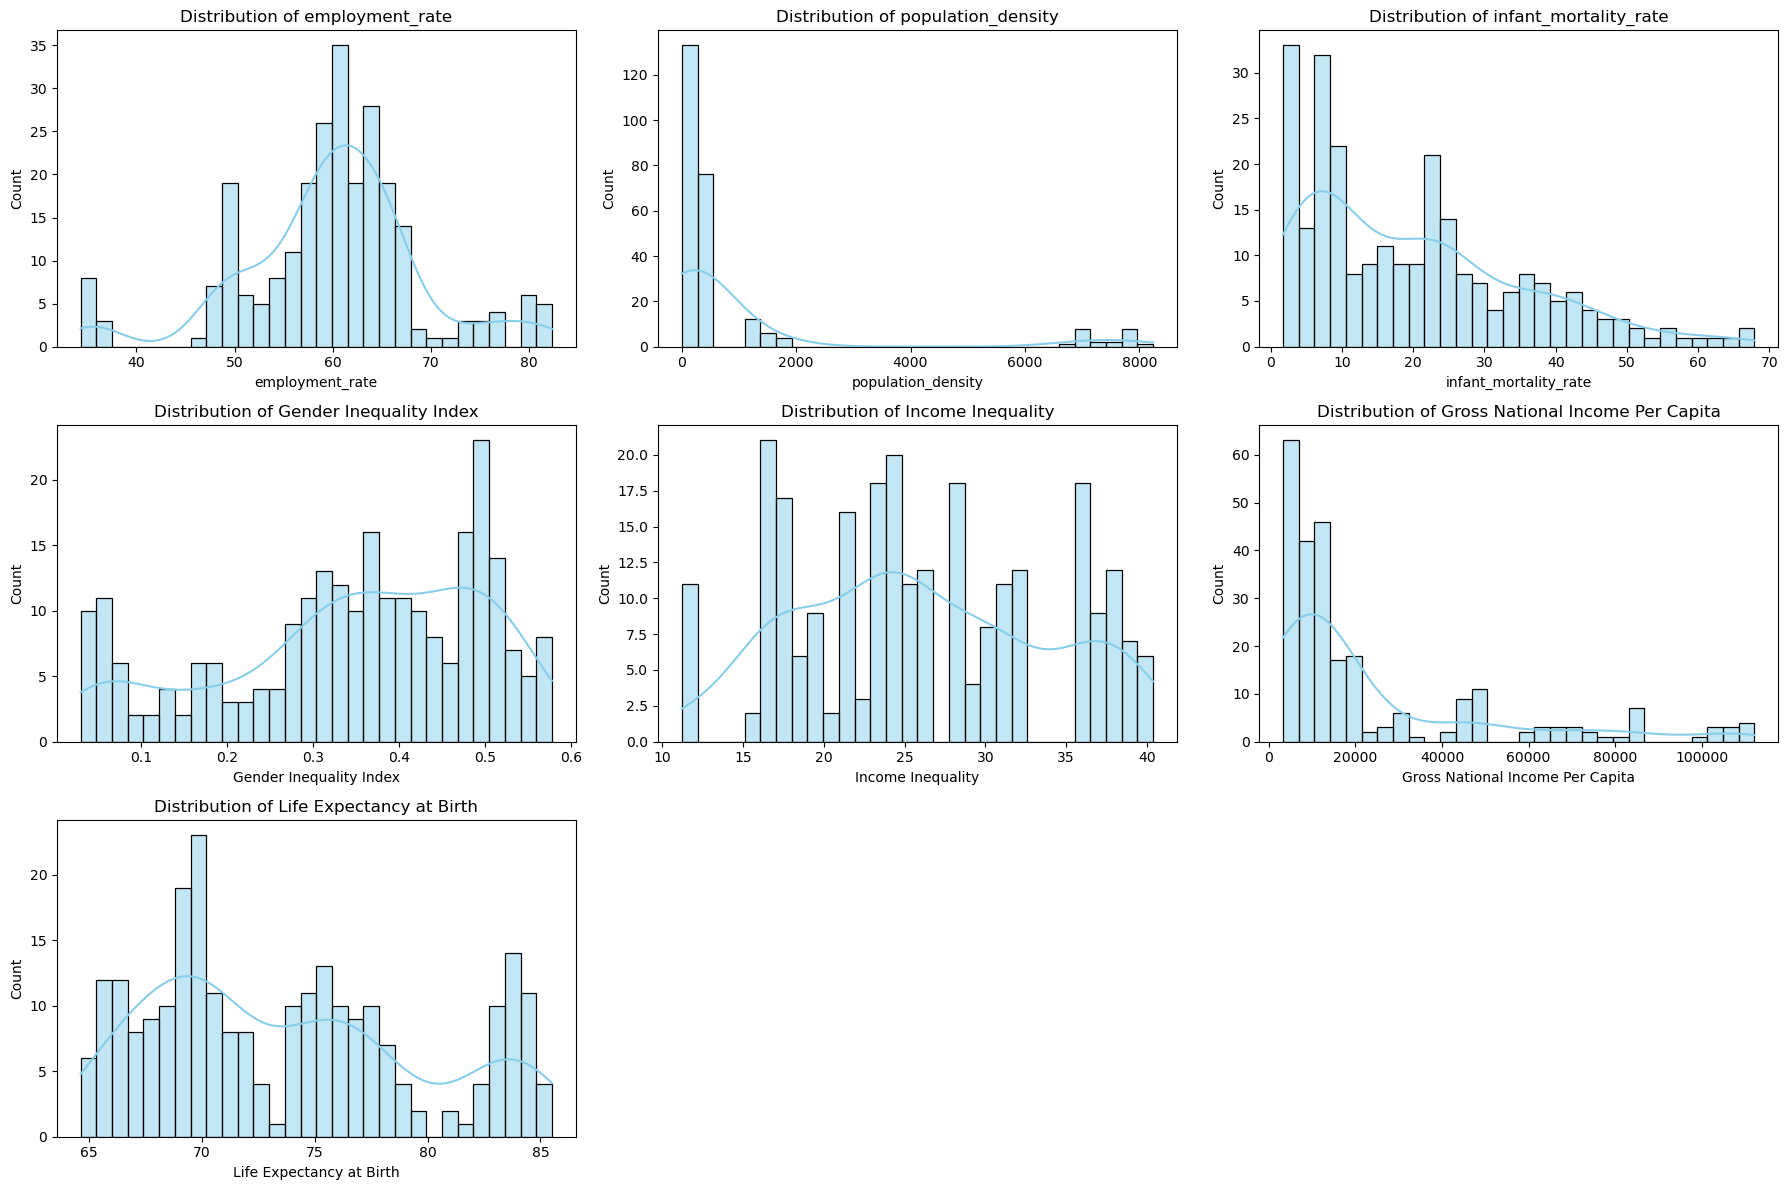

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming your dataset is se_data
# Columns: employment_rate, population_density, infant_mortality_rate, Gender Inequality Index, Income Inequality, Gross National Income Per Capita, Life Expectancy at Birth

columns = ['employment_rate', 'population_density', 'infant_mortality_rate', 
           'Gender Inequality Index', 'Income Inequality', 
           'Gross National Income Per Capita', 'Life Expectancy at Birth']

plt.figure(figsize=(18, 12))

for i, col in enumerate(columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(se_data[col], bins=30, kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


What do we do with values?

new displacement --> number of people | depends, could improve in the future if we apply log transform (some models can deal without it, but linear models probably not)

emplyment rate --> 0-100% is fine

population density --> not sure | log transform?

infant mortality --> not sure | log transform

gii --> 0-1 so make 0-100 then fine

income --> 0-100 is fine

gni --> not sure | log transform

life expectancy --> not sure 

normalize all

In [100]:
se_data.to_csv("socio_economic_data.csv", index=False)
disp_data.to_csv("displacement_data.csv", index=False)

In [102]:
disp_data = pd.read_csv("displacement_data.csv")
se_data = pd.read_csv("socio_economic_data.csv")

  iso3  year  start_date  new_displacement hazard_type_name
0  BGD  2013  2013-07-01              8400            Flood
1  BGD  2013  2013-06-01             14280            Flood
2  BGD  2013  2013-03-23             37149            Storm
3  BGD  2013  2013-05-16           1100000            Storm
4  CHN  2013  2013-07-09               200    Mass Movement
